# Klasyfikacja za pomocą naiwnej metody bayesowskiej (rozkłady ciągłe)

Skład grupy:
- Nowak Ania,
- Łaźna Patrycja,
- Bregier Damian

In [1]:
#!pip install pandas==1.2.4
#!pip install numpy==1.20.3
#!pip install sklearn==0.0

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import typing
import os, pickle
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# 0. Podstawowe informacje o zbiorze danych

W projekcie wykorzystany został GTZAN Dataset poruszający problem wieloklasowej klasyfikacji danych na przykładzie gatunków muzycznych. Zbiór ten składa się z 10 gatunków obejmujacych: blues, muzykę klasyczną, country, disco, hip-hop, jazz, pop, reggae oraz rock. Każdy ze wspomnianych gatunków jest reprezentowany przez 100 plików audio o długości 30 sekund, a same próbki były zbierane w latach 2000-2001 ze zdyfersyfikowanych źródeł obejmujących: stacje radiowe, prywatne płyty CD oraz nagrania własne.

Zbiór danych jest niezwykle bogaty i rozbudowany, ponieważ do każdego utworu zostało przypisanych 60 unikalnych parametrów. Parametry te obejmują takie dane jak: długość utworu, etykietę z nazwą gatunku, tempo, harmoniczność, variancję czy częstotliwość melodyczną (MFCC).

Dokładne dane na temat tego zbioru danych można znaleźć pod adresem: https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification



# 1. Wczytywanie i normalizacja danych

In [2]:
# Słownik zawierający 10 gatunków muzycznych, które zostały sparowane z
# odpowiadającymi im wartościami numerycznymi
genre_dict = {
    "blues" : 1,
    "classical" : 2,
    "country" : 3,
    "disco" : 4,
    "hiphop" : 5,
    "jazz" : 6,
    "metal" : 7,
    "pop" : 8,
    "reggae" : 9,
    "rock" : 10
}
# nazwa pliku w którym umieszczane są parametry po wstępnym przetworzeniu
filename = 'music_genre.csv'
model_path = 'model.model'

In [3]:
# skrypt ten realizuje dwie podstawowe funkcje
# 1) sprawdza czy plik music_genre.csv istnieje i jeżeli tak to wczytuje go
# 2) w przeciwnym przypadku dokonuje preprocessingu danych w ramach którego
#    gatunki zamieniane są na wartości licznowe, a wartości takie jak nazwa 
#    pliku, etykieta czy długość są usuwane
 
if os.path.isfile(filename):
    print("Loading prepared data...")
    data = pd.read_csv(filename)
else:
    print("Preparing data...")
    data = pd.read_csv('music_genre_raw.csv')
    column = data["label"].apply(lambda x: genre_dict[x])
    data.insert(0, 'genre', column, 'int')
    data = data.drop(columns=['filename', 'length'])
    data.to_csv(filename, index=False)
display(data.head(10))

data.columns

Preparing data...


genre  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      1          0.350088         0.088757  0.130228  0.002827   
1      1          0.340914         0.094980  0.095948  0.002373   
2      1          0.363637         0.085275  0.175570  0.002746   
3      1          0.404785         0.093999  0.141093  0.006346   
4      1          0.308526         0.087841  0.091529  0.002303   
5      1          0.302456         0.087532  0.103494  0.003981   
6      1          0.291328         0.093981  0.141874  0.008803   
7      1          0.307955         0.092903  0.131822  0.005531   
8      1          0.408879         0.086512  0.142416  0.001507   
9      1          0.273950         0.092316  0.081314  0.004347   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1784.165850           1.297741e+05              2002.449060   
1             1530.176679           3.758501e+05              2039.036516   
2             1552.811865           1.564676e+05              1747.702312   
3             1070.106615           1.843559e+05              1596.412872   
4             1835.004266           3.433999e+05              1748.172116   
5             1831.993940           1.030482e+06              1729.653287   
6             1459.366472           4.378594e+05              1389.009131   
7             1451.667066           4.495682e+05              1577.270941   
8             1719.368948           1.632828e+05              2031.740381   
9             1817.150863           2.982361e+05              1973.773306   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0            85882.761315   3805.839606  ...   52.420910    -1.690215   
1           213843.755497   3550.522098  ...   55.356403    -0.731125   
2            76254.192257   3042.260232  ...   40.598766    -7.729093   
3           166441.494769   2184.745799  ...   44.427753    -3.319597   
4            88445.209036   3579.757627  ...   86.099236    -5.454034   
5           201910.508633   3481.517592  ...   72.549225    -1.838263   
6           185023.239545   2795.610963  ...   83.248245   -10.913176   
7           168211.938804   2954.836760  ...   70.438438   -10.568935   
8           105542.718193   3782.316288  ...   50.563751    -7.041824   
9           114070.112591   3943.490565  ...   59.314602    -1.916804   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.524071    -0.408979   41.597103    -2.303523   55.062923     1.221291   
1   60.314529     0.295073   48.120598    -0.283518   51.106190     0.531217   
2   47.639427    -1.816407   52.382141    -3.439720   46.639660    -2.231258   
3   50.206673     0.636965   37.319130    -0.619121   37.259739    -3.407448   
4   75.269707    -0.916874   53.613918    -4.404827   62.910812   -11.703234   
5   68.702026    -2.783800   42.447453    -3.047909   39.808784    -8.109991   
6   56.902153    -6.971336   38.231800    -3.436505   48.235741    -6.483466   
7   52.090893   -10.784515   60.461330    -4.690678   65.547516    -8.630722   
8   28.894934     2.695248   36.889568     3.412305   33.698597    -2.715692   
9   58.418438    -2.292661   83.205231     2.881967   77.082222    -4.235203   

   mfcc20_var  label  
0   46.936035  blues  
1   45.786282  blues  
2   30.573025  blues  
3   31.949339  blues  
4   55.195160  blues  
5   46.311005  blues  
6   70.170364  blues  
7   56.401436  blues  
8   36.418430  blues  
9   91.468811  blues  

[10 rows x 59 columns]

Index(['genre', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var',
       'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
       'label']

# 2. Podział danych na zbiory: uczący i testowy

In [4]:
# Podział ten jest dokonywany w proporcji 80:20, gdzie 80% danych trafia do zbioru uczącego, a 20%
# do zbioru testowego, podejście to jest standardową praktyką w dziedzinie uczenia maszynwego

# wartość X reprezentuje 57 parametrów opisujących poszczególne utwory
X = data.drop(["genre"], axis=1)
# wartość Y zawiera kolumnę gatunków wyrażonych przy pomocy wartości liczbowych od 1 do 10
Y = data["genre"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = False)
display(X_train.head(10))

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
687          0.516547         0.072241  0.267380  0.001175   
500          0.344511         0.085002  0.046747  0.001542   
332          0.368345         0.090390  0.111073  0.004402   
979          0.360042         0.083953  0.116724  0.000789   
817          0.425788         0.091852  0.139799  0.003601   
620          0.495959         0.072854  0.117362  0.000867   
814          0.395137         0.093939  0.114246  0.004025   
516          0.249535         0.087563  0.060560  0.001276   
518          0.353474         0.087755  0.052264  0.000316   
940          0.416089         0.087772  0.142935  0.003150   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
687             3338.581900          172002.893292              2697.128636   
500             1503.869486          554576.511533              1754.216082   
332             2446.919077          490397.099115              2449.159840   
979             2148.410463          253618.158995              2107.165355   
817             1803.774378          659241.158049              1973.418903   
620             2657.912854          189139.438926              2345.662472   
814             1716.249594          920189.339374              2062.885827   
516             1465.857446          143302.098295              1738.858902   
518             1993.352766           64753.479332              2127.165109   
940             3009.958707          435134.775688              2778.049758   

     spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_var  \
687            45771.294278   6670.863091  3.556853e+05  ...   37.339474   
500           283554.933422   2799.283099  2.685679e+06  ...   50.311016   
332           215375.540632   4958.057490  2.650020e+06  ...   78.892769   
979            72155.551685   4479.264304  9.787046e+05  ...   37.060532   
817           201432.199120   3777.969679  2.632339e+06  ...   64.068756   
620            32730.579626   5358.261979  5.918222e+05  ...   27.937113   
814           358557.016423   3790.901258  4.734865e+06  ...   66.090370   
516            58868.399307   2822.406728  7.392007e+05  ...  109.811813   
518            36027.039069   4248.194549  3.987029e+05  ...   57.230133   
940           135548.871316   6131.200719  1.788624e+06  ...   42.315434   

     mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
687    -8.121326   33.968277     4.910113   42.063385    -2.474697   
500    -1.503434   41.141155     0.221949   55.707256    -1.991485   
332    -1.054999   79.877068     4.496278  112.834435    -0.978958   
979   -13.479134   50.848667     3.308529   47.726006    -3.704957   
817    -2.219202   99.249870     5.304260   64.088127    -6.597187   
620   -10.676390   26.519361     3.875155   25.613684    -4.943561   
814    -4.590122   72.595345     4.261040   63.185764    -2.127876   
516    -0.027696  113.660950     2.098475  160.025497     1.109709   
518    -1.110214   48.080849    -0.784249   57.033504    -2.984207   
940    -3.953057   48.761936    -3.092345   49.514446    -2.731183   

     mfcc19_var  mfcc20_mean  mfcc20_var   label  
687   35.162354     3.192656   36.478157   metal  
500   50.006485    -3.353825   49.906403    jazz  
332   75.059898    -5.256925  120.275269   disco  
979   56.781952     1.085497   54.243389    rock  
817   62.661850    -2.923168   67.490440  reggae  
620   24.334734     3.255899   25.199259   metal  
814   50.693245    -3.665569   89.750290  reggae  
516  136.810165     2.935807   95.914490    jazz  
518   55.737625     0.350456   64.126846    jazz  
940   58.219994    -0.909785   63.111858    rock  

[10 rows x 58 columns]

### Ilość krotek dla poszczególnych gatunków z podziałem na zbiory: uczący i testowy

In [5]:
# skrypt odpowiadający za przeiterowanie po słowniku i zliczenie liczebności poszczególnych gatunków
# w ramach podziału na zbiory: uczący i testowy

for key in genre_dict.keys():
    count = len(data[data["genre"]==genre_dict[key]])
    count_train = len(X_train[Y_train==genre_dict[key]])
    count_test = len(X_test[Y_test==genre_dict[key]])
    print(f"{key}\ttest: {count_test}\ttrain: {count_train}\tall: {count}")

blues	test: 15	train: 85	all: 100
classical	test: 11	train: 89	all: 100
country	test: 27	train: 73	all: 100
disco	test: 22	train: 78	all: 100
hiphop	test: 23	train: 77	all: 100
jazz	test: 18	train: 82	all: 100
metal	test: 20	train: 80	all: 100
pop	test: 24	train: 76	all: 100
reggae	test: 15	train: 85	all: 100
rock	test: 25	train: 75	all: 100


# 3. Wizualizacja danych

### Boxplot dla tempa gatunków

Jedną z najciekawszych i najbardziej intuicyjnych wartości mierzalnych dla poszczególnych utworów jest tempo. Parametr ten został przedstawiony przy pomocy wykresu pudełkowego w odniesieniu do wspomnianych wcześniej 10 gatunków muzycznych.

Ze zgromadzonych danych jednoznacznie wynika, że najwyższą medianę dla tempa mają utwory z gatunku Reggee, zaś na drugim i trzecim miejscu znajdują się odpowiednio muzyka klasyczna oraz blues. Podczas gdy najniższe wartości mają gatunki hip-hop oraz pop. 

Z kolei największe rozbieżności pomiędzy wartościami zauważalne są w przypadku muzyki klasycznej, country i metalu, chociaż najwięcej obserwacji odstających pojawia się w przypadku hiphopu oraz popu.

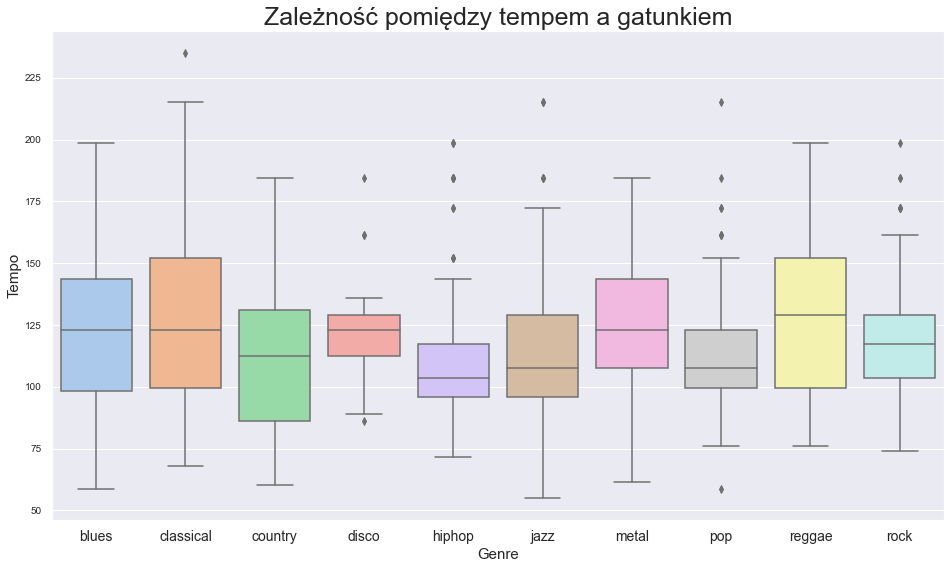

In [6]:
f, ax = plt.subplots(figsize=(16, 9));

sns.boxplot(x = "label", y = "tempo", data = data[["label", "tempo"]], palette = 'pastel');

plt.title('Zależność pomiędzy tempem a gatunkiem', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("Tempo", fontsize = 15);

### Boxplot dla średnich melowych współczynników cepstralnych sygnału dla poszczególnych gatunków

Interesujące wyniki pojawiły się także na wykresie pokazującym zależność pomiędzy MFCC mean, czyli średnimi wartościami dla melowych współczynników cepstralnych sygnału a gatunkami muzycznimi. 

Najwyższe wartości MFCC_mean dotyczą metalu oraz bluesa, podczas gdy najniższe wartości uzyskiwane są w przypadu popu i muzyki klasycznej. Z kolei najwięcej obserwacji odstających pojawia się w przypadku reggae.

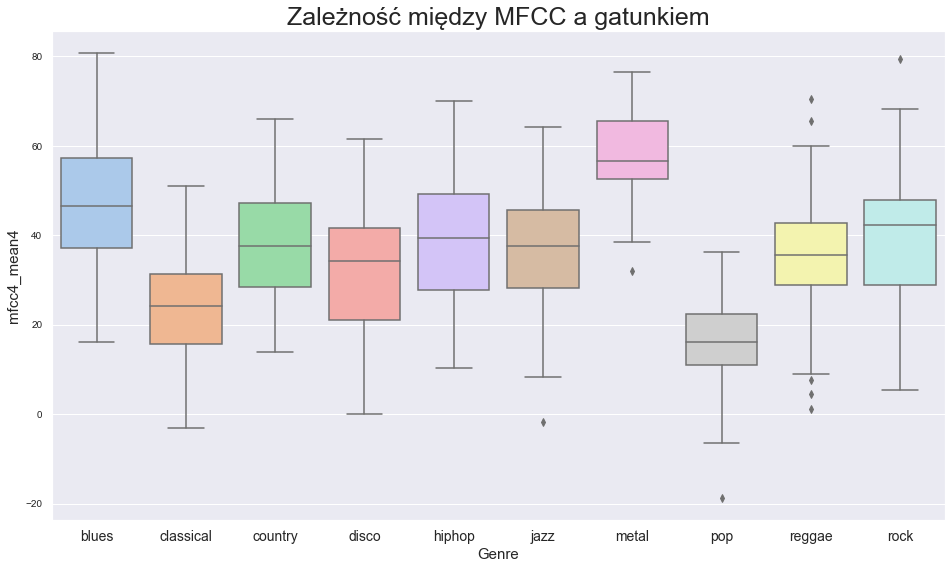

In [7]:
f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "mfcc4_mean", data = data[["label", "mfcc4_mean"]], palette = 'pastel');

plt.title('Zależność między MFCC a gatunkiem', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("mfcc4_mean4", fontsize = 15);

### Korelacja między cechami średnimi

W procesie badania zależności pomiędzy dostępnymi cechami wykorzystana została mapa ciepła, która jednak pokazała, że w wielu przypadkach korelacje nie zachodzą, co jest szczególnie widoczne w przypadku średniej częstotliwości melodycznej cepstrum2 (mfcc2_mean), a jeżeli takowe korelacje zachodza to mają stosunkowo niewielkie wartości.Występowanie zależności widać w górnej oraz środkowej częsci mapy.

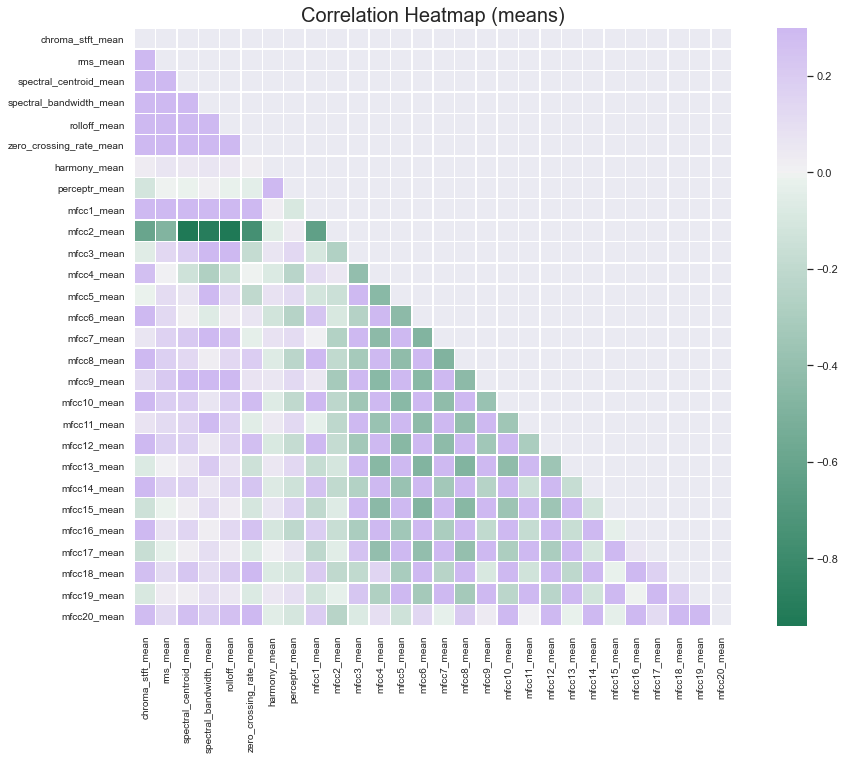

In [8]:
mean_cols = [col for col in data.columns if 'mean' in col]
mean_correlation = data[mean_cols].corr()


mask = np.triu(np.ones_like(mean_correlation, dtype=bool))
f, ax = plt.subplots(figsize=(16, 11))
cmap = sns.diverging_palette(150, 275, as_cmap=True, s = 90, l = 45, n = 5)

sns.heatmap(mean_correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

plt.title('Correlation Heatmap (means)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

### Korelacja między cechami wariancji

Odwrotna sytuacja ma miejsce w przypadku mapy ciepła dla cech wariancji, w przypadku ktorych korelacja nie zachodzi wyłącznie dla dwóch parametrów czyli harmony i perceptr w środkowej cześci wykresu. Z kolei stosunkow wysokie wartości korelacji można zaobserwować dla parametrów "skrajnych", czyli pierwszych i ostatnich na liście parametrów.


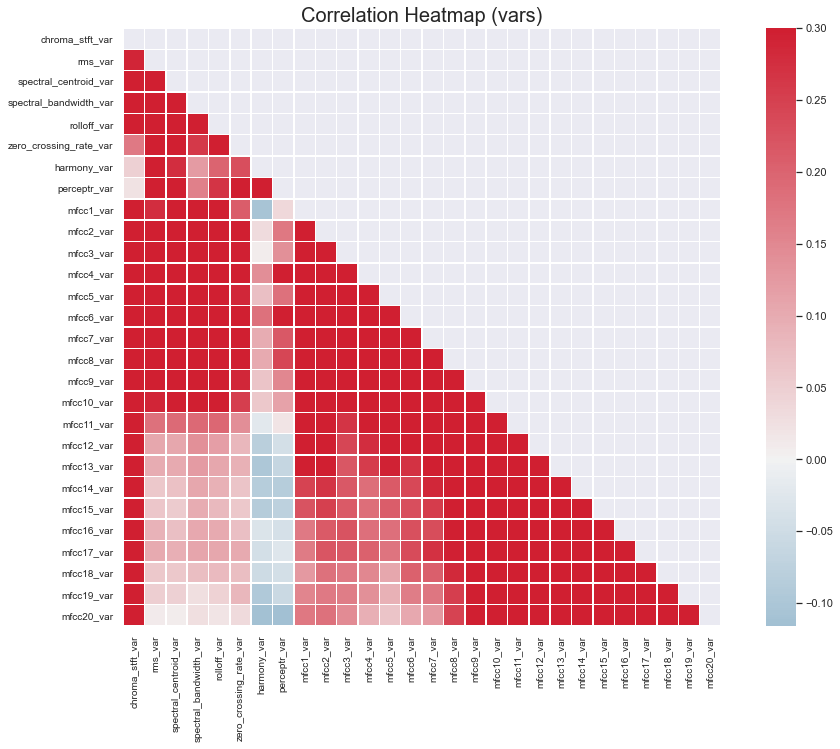

In [9]:
var_cols = [col for col in data.columns if 'var' in col]
var_correlation = data[var_cols].corr()


mask = np.triu(np.ones_like(var_correlation, dtype=bool))
f, ax = plt.subplots(figsize=(16, 11))
cmap = sns.diverging_palette(240, 10, as_cmap=True, s = 90, l = 45, n = 5)

sns.heatmap(var_correlation, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

plt.title('Correlation Heatmap (vars)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

## Cechy średnie dają lepsze rezultaty niż cechy wariancji ze względu na mniejszą korelację pomiędzy poszczególnymi parametrami.(https://datascience.stackexchange.com/questions/9087/correlation-and-naive-bayes). 

W toku przeprowadzanych testów okazało sie, że dokładność stworzonego i wytrenowanego modelu zależy od rodzaju cech. W przypadku cech wariancji dokładność jest niższa niż w przypadku cech średnich. Z kolei najwyższą dokładność udało się uzyskać poprzez wykorzystanie kombinacji 8 różnych kolumn.

- dla var_cols accuracy = 0.3875,
- dla mean_cols accuracy = 0.4375,
- dla ['mfcc4_mean', 'mfcc12_mean', 'mfcc9_var', 'mfcc1_mean', 'rms_mean', 'chroma_stft_mean', 'mfcc6_var', 'mfcc9_mean'] accuracy = 0.56125 

Równocześnie uzyskane wyniki mogłyby mieć zdecydowanie wyższą dokładność jednak ograniczeniem okazał się specyfika samego datasetu, który posiada niewielkie zróżnicowanie wartości cech i niewielką korelację pomiędzy poszczególnymi cechami!

### Wykres punktowy przedstawiający zależność pomiędzy chroma_stft_mean (wysokością dźwięku) a mfcc12_mean (melowym współczynnikiem cepstralnym )

Wykres ten pokazuje, że chociaż pojawia się pewna pula obserwacji odstających, to jednak wraz ze wzrostem wartości mfcc12_mean rosną wartości chroma_stft_mean. Tym samym zależność pomiędzy tymi dwiema wartościami, w ogólności, ma charakter liniowy, co potwierdza wynik uzyskany na heatmapie, gdzie korelacja wynosiła 0.2.

<ipython-input-10-bcf947f4e0ac>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()


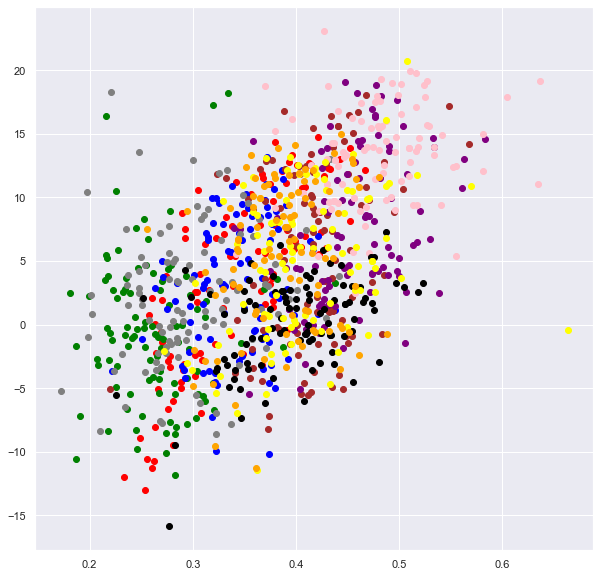

In [10]:
fig = plt.figure(figsize=(10,10))
chart = fig.add_subplot()
ax = fig.add_subplot()
colors = ['red', 'green', 'blue', 'brown','purple', 'gray', 'pink', 'black', 'yellow', 'orange']
for genre in genre_dict:
    genre_data = data[data["genre"]==genre_dict[genre]]
    ax.scatter(genre_data['chroma_stft_mean'],genre_data['mfcc12_mean'], c=colors[genre_dict[genre]-1])
plt.show()

# 4. Wykorzystanie algorytmu Bayesa

In [11]:
class NaiveBayesContinues:
    def __init__(self, X, Y):
        self.classes = Y.unique()
        self.priors = [] # prawdopodobieństwo każdej z klas
        self.stds = [] #lista odchyleń standardowych każdej z cech dla każdej z klas
        self.means = [] #lista średnich dla każdej z cech dla każdej z klas
        for c in self.classes:
            x_with_c_class = X[c == Y]
            self.priors.append(len(x_with_c_class) / len(X))
            self.means.append(x_with_c_class.mean(axis=0))
            self.stds.append(x_with_c_class.std(axis=0))

            
    def predict(self, X, display_results=False):
        y_preds = []
        for x in X:
            posteriors = []
            for i, c in enumerate(self.classes):
                prior = self.priors[i] # prawdopodobieństwo dla rozpatrywanej klasy
                mean = self.means[i] # średnia cech dla rozpatrywanej klasy
                std = self.stds[i] # odchylenie standardowe cech dla rozpatrywanej klasy
                
                posterior = 1 #P(X1|Yi)*P(X2|Yi)*P(X3|Yi)...
                for j, feature in (enumerate(x)):
                    P_X_yi = np.exp((-(feature - mean[j]) ** 2) / (2 * std[j] ** 2)) / np.sqrt(2 * np.pi * std[j] ** 2) #P(Xj|Yi)
                    posterior *= P_X_yi
                
                posterior = (posterior * prior) #P(Yi)P(X1|Yi)*P(X2|Yi)*P(X3|Yi)...
                posteriors.append(posterior)
                
            if(display_results):
                print("posteriors")
                print(posteriors)
                print(np.argmax(posteriors))
                
            y_pred = self.classes[np.argmax(posteriors)] # Wzięcie klasy z największym prawdopodobieństem
            y_preds.append(y_pred)
        return y_preds

Wzór bayesa
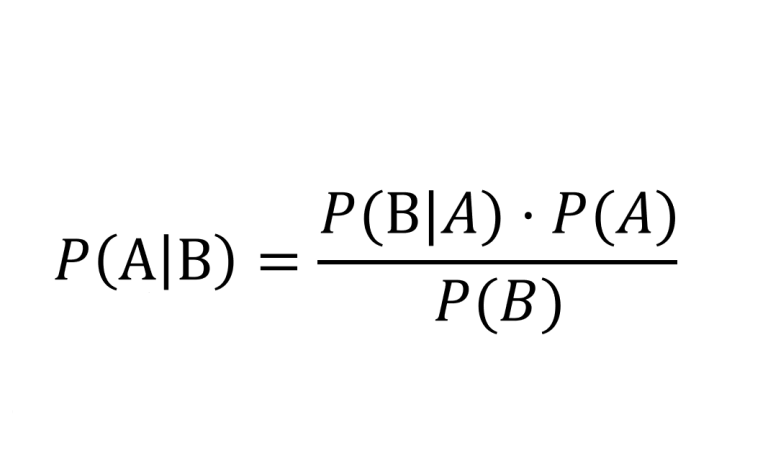


Gausowski Naiwny Bayes
Stosowany w przypadku pracy na danych o charakterze ciągłym.
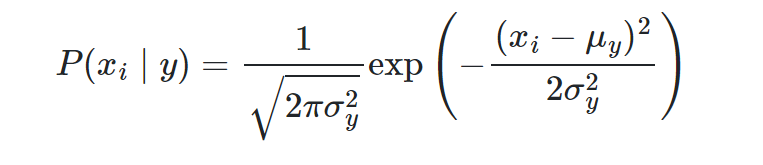

W procesie trenowania i testowania modelu wykorzystany został skrypt losujący kolumny i zapisujący uzyskiwane wartości accuracy w celu znalezienia najbardziej efektywnej kombinacji cech. W ten sposób wybranych zostało 8 cech, w tym sześć cech należących do kategorii średnich i dwie do wariancji.

In [12]:
X_train_np = X_train[['mfcc4_mean', 'mfcc12_mean', 'mfcc9_var', 'mfcc1_mean', 'rms_mean', 'chroma_stft_mean', 'mfcc6_var', 'mfcc9_mean']].to_numpy()
X_test_np = X_test[['mfcc4_mean', 'mfcc12_mean', 'mfcc9_var', 'mfcc1_mean', 'rms_mean', 'chroma_stft_mean', 'mfcc6_var', 'mfcc9_mean']].to_numpy()

model = NaiveBayesContinues(X_train_np, Y_train)

In [13]:
Y_train_predicted = model.predict(X_train_np[:1])

# Ewaluacja

### Zbiór trenujący

In [14]:
Y_train_predicted = model.predict(X_train_np)
cm = confusion_matrix(Y_train, Y_train_predicted)
ac = accuracy_score(Y_train, Y_train_predicted)
print("(Train data) Confusion matrix:")
display(cm)
print("(Train data) Accuracy:")
print(ac)

(Train data) Confusion matrix:


array([[27,  3, 11,  3,  1,  8, 18,  0, 10,  4],
       [ 1, 75,  2,  0,  0, 10,  0,  0,  1,  0],
       [10,  1, 29,  9,  1,  4,  2,  8,  6,  3],
       [ 2,  0,  2, 39,  1,  1, 12, 12,  5,  4],
       [ 0,  0,  0,  8, 36,  0, 11, 13,  8,  1],
       [ 8, 20,  2,  0,  0, 45,  1,  0,  0,  6],
       [ 1,  0,  0,  3,  2,  0, 71,  0,  0,  3],
       [ 1,  1,  2,  2,  5,  0,  0, 63,  2,  0],
       [ 1,  0,  8,  8,  6,  3,  3,  5, 48,  3],
       [ 4,  0, 10, 15,  0,  6, 14,  5,  5, 16]], dtype=int64)

(Train data) Accuracy:
0.56125


### Zbiór testowy

In [15]:
Y_test_predicted = model.predict(X_test_np)
cm = confusion_matrix(Y_test, Y_test_predicted)
ac = accuracy_score(Y_test, Y_test_predicted)
print("Confusion matrix:")
display(cm)
print("Accuracy:")
print(ac)

Confusion matrix:


array([[ 5,  0,  2,  0,  0,  2,  4,  0,  1,  1],
       [ 0,  8,  0,  0,  0,  3,  0,  0,  0,  0],
       [ 7,  0,  6,  6,  0,  4,  1,  0,  1,  2],
       [ 0,  0,  2,  7,  1,  0,  2,  4,  5,  1],
       [ 0,  0,  0,  2, 10,  0,  6,  1,  4,  0],
       [ 0,  3,  0,  1,  0, 14,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0, 17,  0,  2,  0],
       [ 1,  0,  0,  2,  1,  0,  0, 18,  1,  1],
       [ 0,  1,  0,  0,  3,  1,  0,  4,  6,  0],
       [ 5,  0,  3,  5,  1,  1,  5,  1,  0,  4]], dtype=int64)

Accuracy:
0.475


### Przykładowe porównania

In [16]:
for i in range(10):
    print(f"Y: {Y_test.to_numpy()[i]}\tPredicted: {Y_test_predicted[i]}")

Y: 10	Predicted: 10
Y: 9	Predicted: 8
Y: 3	Predicted: 1
Y: 6	Predicted: 6
Y: 7	Predicted: 7
Y: 10	Predicted: 7
Y: 1	Predicted: 1
Y: 3	Predicted: 6
Y: 4	Predicted: 4
Y: 8	Predicted: 10


# Bayes z wykorzystaniem gotowej biblioteki

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import pickle, os
import typing

class Bayes:
    def __init__(self):
        self.classifier = GaussianNB()


    def train(self, X: pd.DataFrame, Y: pd.Series) -> None:
        self.classifier.fit(X, Y)


    def predict(self, X: pd.DataFrame) -> np.ndarray:
        predictions = self.classifier.predict(X)
        return predictions


    def eval(self, Y: pd.Series, Y_pred: np.ndarray) -> typing.Tuple[np.ndarray, np.float64]:
        cm = confusion_matrix(Y, Y_pred)
        ac = accuracy_score(Y, Y_pred)
        return (cm, ac)

In [18]:
bayes = Bayes()
bayes.train(X_train_np, Y_train)

Y_predicted = bayes.predict(X_train_np)
eval_result = bayes.eval(Y_train, Y_predicted)
print("Train:")
print(eval_result[1])

Y_predicted = bayes.predict(X_test_np)
eval_result = bayes.eval(Y_test, Y_predicted)
print("Test:")
print(eval_result[1])

Train:
0.56125
Test:
0.475


In [19]:
# skrypt losujacy kolumny ze zbioru i sprawdzajacy accuracy na zbiorze trenujacym

for i in range(100):
    X = data.drop(["genre", "label", "tempo"], axis=1)
    X_rand = X.sample(n=10, axis='columns')
    Y = data["genre"] 
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_rand, Y, test_size = 0.20, random_state = False)
    
    model = GaussianNB()
    model.fit(X_train, Y_train)
    Y_train_predicted = model.predict(X_train)
    ac = accuracy_score(Y_train, Y_train_predicted)
    filename = 'accuracy.txt'

    if os.path.exists(filename):
        append_write = 'a'
    else:
        append_write = 'w'

    acc_random = open(filename, append_write)
    acc_random.write(str(ac) + " " + str(list(X_rand.columns)) + '\n')
    acc_random.close()

#!sort -k1,1nr -k2,2 accuracy.txt